In [1]:
import difflib
import json
import os
import re

import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sentence_transformers import SentenceTransformer, util

from language_classifier.language_classifier import LanguageClassifier

# formatting
pd.set_option('display.float_format', '{:.1f}'.format)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_colwidth', 200)

# import data

In [2]:
# folders
parsed_docs_folder = os.path.join("..", "ParsedPublications")
fr_eng_correlation_csv = "fr_eng_correlation_data.csv"

fr_eng_correlation_df = pd.read_csv(fr_eng_correlation_csv)

# weblinks for previewing / testing
weblinks_df = fr_eng_correlation_df.copy()
weblinks_df = weblinks_df[['pub_number', 'nom', 'name', 'url_fr', 'url_en', 'file_url_fr', 'file_url_en']]

# simplified correlation table
fr_eng_correlation_df = fr_eng_correlation_df[['pub_number', 'filename_fr', 'filename_en']]

# helper functions

In [3]:
# DATA CLEANING FUNCTIONS

def clean_text(text):

    allowed_chars = r"[^a-zA-ZÀ-ÖØ-öø-ÿ.,;:!?()'\"-]"
    text = re.sub(allowed_chars, ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()

    return text


def get_files_for_publication(pub_number, fr_eng_correlation_df):
    row = fr_eng_correlation_df.loc[fr_eng_correlation_df['pub_number'] == pub_number]
    if not row.empty:
        filename_fr = row['filename_fr'].values[0]
        filename_en = row['filename_en'].values[0]
        return filename_fr, filename_en
    return None, None


def get_json_file_link(parsed_docs_folder, pdf_filename):
    if pdf_filename.endswith(".pdf"):
        json_filename = pdf_filename + ".json"
        for root, _, files in os.walk(parsed_docs_folder):
            if json_filename in files:
                return os.path.join(root, json_filename)
    return None


def extract_text_from_single_file(json_file, target_language, clf):
    with open(json_file, 'r', encoding='utf-8') as file:
        data = json.load(file)

    if 'text' not in data:
        raise KeyError(f"The key 'text' is missing in the JSON file: {json_file}")
    
    full_text = clean_text(data['text'])
    # text_blocks = re.split(r'(?<![;,])[.?!\n]', full_text)  # TODO: remove if the other thing is better
    text_blocks = re.split(r'(?<![;,])([.?!]\s|\n\n)', full_text)
    text = []

    for block in text_blocks:
        block = block.strip()
        if not block:
            continue
            
        if clf.classify(block) == target_language:
            text.append(block + '. ')      

    return " ".join(text)


def extract_both_languages_from_two_files(json_file_fr, json_file_en, clf):
    return extract_text_from_single_file(json_file_fr, "fr", clf), extract_text_from_single_file(json_file_en, "en", clf)


def extract_both_languages_from_single_file(json_file, clf):
    with open(json_file, 'r', encoding='utf-8') as file:
        data = json.load(file)

    if 'text' not in data:
        raise KeyError(f"The key 'text' is missing in the JSON file: {json_file}")
    
    full_text = data['text']
    text_blocks = re.split(r'[.\n?]', full_text)
    text_fr, text_en = [], []

    for block in text_blocks:
        block = block.strip()
        if not block:
            continue
            
        if clf.classify(block) == "fr":
            text_fr.append(block + '. ')   
        elif clf.classify(block) == "en":
            text_en.append(block + '. ')   

    return " ".join(text_fr), " ".join(text_en)


def correlate_and_clean_text(text_fr, text_en):
    # TODO: update this to similarity matrix method
    matcher = difflib.SequenceMatcher(None, text_fr.split(), text_en.split())
    matched_fr, matched_en = [], []
    
    for tag, i1, i2, j1, j2 in matcher.get_opcodes():
        if tag == 'equal':
            matched_fr.append(" ".join(text_fr.split()[i1:i2]))
            matched_en.append(" ".join(text_en.split()[j1:j2]))
    
    return matched_fr, matched_en


def process_all_rows(fr_eng_correlation_df, parsed_docs_folder, clf):
    debug = True  # TODO: remove after DEBUG
    
    matched_data = []
    min_text_quality = 1
    
    for _, row in fr_eng_correlation_df.iterrows():
        pub_number = row['pub_number']
        filename_fr, filename_en = row['filename_fr'], row['filename_en']
        
        if filename_fr == "WITHDRAWN" and filename_en == "WITHDRAWN":
            continue
        
        fr_link = get_json_file_link(parsed_docs_folder, filename_fr)
        if fr_link == None:
            continue
        
        if filename_fr == filename_en:
            text_fr, text_en = extract_both_languages_from_single_file(fr_link, clf)
        else:
            en_link = get_json_file_link(parsed_docs_folder, filename_en) 
            if en_link == None:
                continue
            text_fr, text_en = extract_both_languages_from_two_files(fr_link, en_link, clf            )
        
        if debug:
            matched_fr, matched_en = text_fr, text_en  # TODO: remove after DEBUG
        else:            
            matched_fr, matched_en = correlate_and_clean_text(text_fr, text_en)  # TODO: confirm
        
        matched_data.append({'pub_number': pub_number, 'text_fr': matched_fr, 'text_en': matched_en})
    
    return pd.DataFrame(matched_data)


def preview_publication(pub_number):
    if type(pub_number) is pd.DataFrame and pub_number.shape[0] == 1:
        try:
            pub_number = pub_number['pub_number'].values[0]
        except ValueError:
            return None
    elif type(pub_number) is pd.Series:
        try:
            pub_number = pub_number.values[0]
        except ValueError:
            return None
    
    try:
        output_df = weblinks_df[weblinks_df.pub_number == pub_number].T
    except Exception as e:
        print(e)
        return None
        
    display(output_df)


def preview_publication_by_row(row_n):
    display(pd.DataFrame(matched_df.iloc[row_n]))
    preview_publication(matched_df.iloc[row_n].pub_number)


In [4]:
clf = LanguageClassifier()

matched_df = process_all_rows(fr_eng_correlation_df, parsed_docs_folder, clf)
matched_df['len_fr'] = matched_df['text_fr'].str.len()
matched_df['len_en'] = matched_df['text_en'].str.len()
matched_df['len_diff'] = np.where(
    matched_df[['len_fr', 'len_en']].min(axis=1) == 0,
    999,
    matched_df[['len_fr', 'len_en']].max(axis=1) / matched_df[['len_fr', 'len_en']].min(axis=1)
)

In [5]:
# TODO: UPDATE THIS


def create_similarity_matrix(text_fr, text_en):
    model = SentenceTransformer('sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2')

    sentences_fr = [x.strip() for x in text_fr.split(".") if x != ""]
    sentences_en = [x.strip() for x in text_en.split(".") if x != ""]
    
    embeddings_fr = model.encode(sentences_fr, convert_to_tensor=True)
    embeddings_en = model.encode(sentences_en, convert_to_tensor=True)

    return util.pytorch_cos_sim(embeddings_fr, embeddings_en)


def plot_similarity_heatmap(similarity_matrix, figsize=(10, 10)):
    fig, ax = plt.subplots(figsize=figsize) 
    
    cmap = mcolors.ListedColormap(["black", "darkblue", "deepskyblue"])
    bounds = [0, 0.6, 0.8, 1]
    norm = mcolors.BoundaryNorm(bounds, cmap.N)

    sns.heatmap(similarity_matrix, cmap=cmap, norm=norm, cbar=False, square=True, linewidths=0, ax=ax)

    ax.tick_params(left=False, bottom=False)

    plt.tight_layout()
    plt.show()


def text_from_row(row_n):
    return matched_df.iloc[row_n]['text_fr'], matched_df.iloc[row_n]['text_en']


def display_similarity_matrix(row_n, inverse=False, figsize=(10, 10)):
    text_fr, text_en = text_from_row(row_n)
    similarity_matrix = create_similarity_matrix(text_fr, text_en)
    if inverse:
        plot_similarity_heatmap(similarity_matrix.T, figsize=figsize)
    else:
        plot_similarity_heatmap(similarity_matrix, figsize=figsize)
    
    
def merge_short_sentences(sentences, min_length=10):
    merged_sentences = []
    buffer = ""

    for sentence in sentences:
        if len(sentence) < min_length:
            buffer += " " + sentence
        else:
            if buffer:
                merged_sentences.append(buffer.strip() + " " + sentence)
                buffer = ""
            else:
                merged_sentences.append(sentence)

    if buffer:
        merged_sentences.append(buffer.strip())

    return merged_sentences


def correlate_and_clean_text(text_fr, text_en):
    # TODO: traverse matrix like tree or A*
    #  skip bad matches for both languages
    #  merge everything between good matches and recheck for match
    
    min_score = 0.7
    
    model = SentenceTransformer('sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2')

    sentences_fr = [x.strip() for x in text_fr.split(".") if x != ""]
    sentences_en = [x.strip() for x in text_en.split(".") if x != ""]
    
    # TODO: merge short sentences

    embeddings_fr = model.encode(sentences_fr, convert_to_tensor=True)
    embeddings_en = model.encode(sentences_en, convert_to_tensor=True)

    similarity_matrix = util.pytorch_cos_sim(embeddings_fr, embeddings_en)

    matched_fr, matched_en = [], []
    used_en_indices = set()

    for i, emb_fr in enumerate(embeddings_fr):
        scores = similarity_matrix[i]
        best_match_idx = scores.argmax().item()
        
        if scores[best_match_idx] > min_score and best_match_idx not in used_en_indices:
            matched_fr.append(sentences_fr[i])
            matched_en.append(sentences_en[best_match_idx])
            used_en_indices.add(best_match_idx)

    return matched_fr, matched_en
    

In [6]:
row_n = 1000
text_fr, text_en = matched_df.iloc[row_n]['text_fr'], matched_df.iloc[row_n]['text_en']
similarity_matrix = create_similarity_matrix(text_fr, text_en)

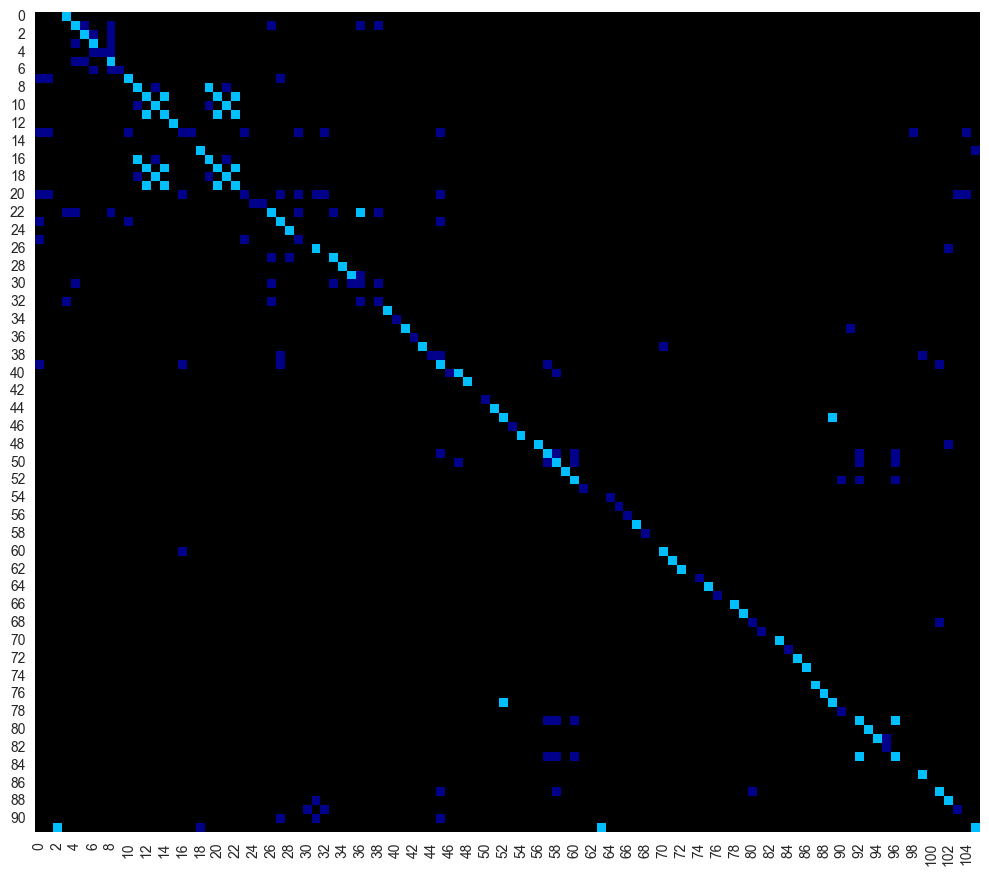

In [7]:
display_similarity_matrix(row_n)

In [8]:
# let's look at the garbage data and see if we can fix it
min_doc_length = 1000
matched_df[((matched_df.len_fr < min_doc_length) | (matched_df.len_en < min_doc_length))].drop(['text_fr', 'text_en'], axis=1).sample(10)

,pub_number,len_fr,len_en,len_diff
1324,RES 1978/027,61,12492,204.8
2570,RES 1992/107,929,12637,13.6
1308,RES 1978/011,0,2949,999.0
8245,SSR 1996/026,0,6741,999.0
80,PRO 1999/022,0,21913,999.0
5709,RES 2017/043,820,20848,25.4
8587,SSR 1999/A6-14,39,2480,63.6
1608,RES 1983/002,986,13661,13.9
1726,RES 1984/031,691,5693,8.2
102,PRO 1999/026,593,59180,99.8


In [9]:
matched_df.iloc[4000, 3:]

len_fr       3377
len_en      69365
len_diff     20.5
Name: 4000, dtype: object

In [10]:
n = 4000
# display_similarity_matrix(n)
text_fr, text_en = matched_df.iloc[n, 1], matched_df.iloc[n, 2]
# create_similarity_matrix(text_fr, text_en)
preview_publication_by_row(n)

,4000
pub_number,RES 2002/123
text_fr,Secrétariat canadien de consultation scientifique. Ne pas citer sans. Examen de la biologie et de la pêche des. * La présente série documente les bases scientifiques. des évaluations des resso...
text_en,Canadian Science Advisory Secretariat. Not to be cited without. A review of the biology and fishery of. * This series documents the scientific basis for the. evaluation of fisheries resources ...
len_fr,3377
len_en,69365
len_diff,20.5


,4053
pub_number,RES 2002/123
nom,Examen de la biologie et de la pêche des Embiotocidés de la Colombie-Britannique.
name,A review of the biology and fishery of the Embiotocids of British Columbia.
url_fr,http://www.dfo-mpo.gc.ca/csas-sccs/publications/resdocs-docrech/2002/2002_123-fra.htm
url_en,http://www.dfo-mpo.gc.ca/csas-sccs/publications/resdocs-docrech/2002/2002_123-eng.htm
file_url_fr,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/272802.pdf
file_url_en,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/272802.pdf


In [11]:
diff_max = 5
matched_df[matched_df.len_diff > diff_max].shape[0]

4915

In [12]:
matched_df['len_diff'].describe()

count   8932.0
mean      43.2
std      171.9
min        1.0
25%        1.2
50%        7.9
75%       18.0
max     2911.2
Name: len_diff, dtype: float64

In [13]:
# TODO: remove junk data
min_doc_chars = 1000
max_len_ratio = 5

matched_df.loc[(matched_df.len_fr > min_doc_chars) & (matched_df.len_en > min_doc_chars), 'len_diff'].describe()

count   8066.0
mean      10.8
std       15.2
min        1.0
25%        1.2
50%        5.4
75%       15.5
max      223.3
Name: len_diff, dtype: float64

In [14]:
# TODO: confirm junk by inspection
junk_df = matched_df.loc[(matched_df.len_fr < min_doc_chars) | (matched_df.len_en < min_doc_chars) | (matched_df.len_diff > max_len_ratio)].copy()
junk_pub_numbers = junk_df['pub_number'].to_list() 
junk_df.loc[:, 'year'] = junk_df['pub_number'].str.extract(r'(\d{4})')
junk_df['year'] = pd.to_numeric(junk_df['year'], errors='coerce')

In [15]:
good_df = fr_eng_correlation_df[(~fr_eng_correlation_df.pub_number.isin(junk_pub_numbers)) & (fr_eng_correlation_df.filename_fr != "WITHDRAWN")].copy()
good_df.loc[:, 'year'] = good_df['pub_number'].str.extract(r'(\d{4})')
good_df['year'] = pd.to_numeric(good_df['year'], errors='coerce')

In [16]:
good_df.head()

,pub_number,filename_fr,filename_en,year
0,ESR 2003/002,279108.pdf,276322.pdf,2003
1,ESR 2003/005,280817.pdf,281583.pdf,2003
2,ESR 2003/004,277606.pdf,276323.pdf,2003
3,ESR 2003/003,336493.pdf,336490.pdf,2003
4,ESR 2003/001,336487.pdf,276124.pdf,2003


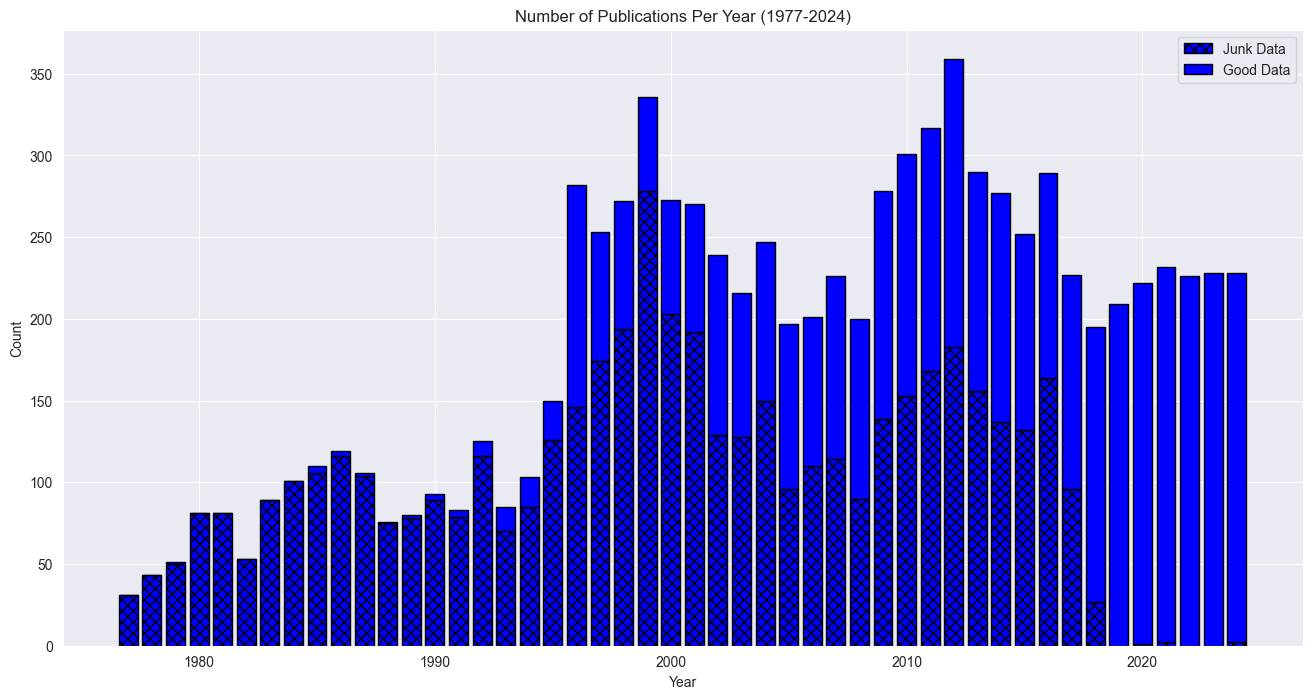

In [17]:
all_years = np.arange(1977, 2025)
junk_year_counts = junk_df['year'].value_counts().reindex(all_years, fill_value=0)
good_year_counts = good_df['year'].value_counts().reindex(all_years, fill_value=0)

plt.figure(figsize=(16, 8))
plt.bar(junk_year_counts.index, junk_year_counts.values, color='blue', edgecolor='black', label='Junk Data', hatch='xxx')
plt.bar(good_year_counts.index, good_year_counts.values, color='blue', edgecolor='black', label='Good Data', bottom=junk_year_counts.values)

plt.xlabel("Year")
plt.ylabel("Count")
plt.title("Number of Publications Per Year (1977-2024)")
plt.legend()

plt.show()

In [18]:
# # CONFIRMED: only fr abstract, all else en 
# preview_publication_by_row(5412)
# preview_publication_by_row(5607)
# preview_publication_by_row(4605)
# preview_publication_by_row(3580)
# preview_publication_by_row(5457)
# preview_publication_by_row(4768)

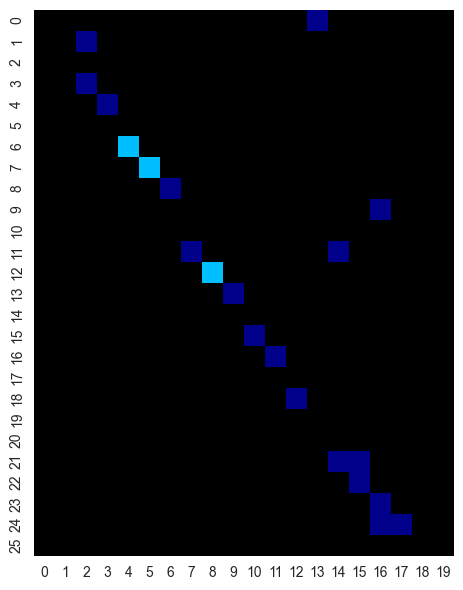

In [19]:
# only the abstract overlaps

text_fr, text_en = text_from_row(5607)
similarity_matrix = create_similarity_matrix(text_fr, text_en)

plot_similarity_heatmap(similarity_matrix[:, 215:235], figsize=(6, 6))

In [20]:
preview_publication_by_row(5607)

,5607
pub_number,RES 2016/066
text_fr,Cadre d'évaluation de la composante des reproducteurs d'automne du hareng de. l'Atlantique (Clupea harengus) dans le sud du golfe du Saint-Laurent (division 4T. de l'OPANO) : modèles de populati...
text_en,Canadian Science Advisory Secretariat (CSAS). Assessment framework for fall-spawning Atlantic herring (Clupea harengus). This series documents the scientific basis for the evaluation of aquatic ...
len_fr,1815
len_en,67938
len_diff,37.4


,5680
pub_number,RES 2016/066
nom,Cadre d'évaluation de la composante des reproducteurs d'automne du hareng de l'Atlantique (Clupea harengus) dans le sud du golfe du Saint-Laurent (division 4T de l'OPANO) : modèles de population e...
name,Assessment framework for fall-spawning Atlantic herring (Clupea harengus) in the southern Gulf of St. Lawrence (NAFO Div. 4T): Population models and status in 2014
url_fr,http://www.dfo-mpo.gc.ca/csas-sccs/Publications/ResDocs-DocRech/2016/2016_066-fra.html
url_en,http://www.dfo-mpo.gc.ca/csas-sccs/Publications/ResDocs-DocRech/2016/2016_066-eng.html
file_url_fr,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/365980.pdf
file_url_en,https://waves-vagues.dfo-mpo.gc.ca/library-bibliotheque/365980.pdf


In [21]:
text_en

'Canadian Science Advisory Secretariat (CSAS).  Assessment framework for fall-spawning Atlantic herring (Clupea harengus).  This series documents the scientific basis for the evaluation of aquatic resources and.  As such, it addresses the issues of the day in the time frames required.  and the documents it contains are not intended as definitive statements on the subjects.  addressed but rather as progress reports on ongoing investigations.  Research documents are produced in the official language in which they are provided to the.  Canadian Science Advisory Secretariat.  © Her Majesty the Queen in Right of Canada, 2016.  Correct citation for this publication:.  Assessment framework for fall-spawning Atlantic herring (Clupea harengus).  LIST OF TABLES.  PART 1: CANDIDATE MODELS.  PART 2: STATUS BASED ON THE PREFERRED MODEL.  DATA UPDATES.  PART 1: CHOICE POPULATION MODEL.  LIST OF TABLES.  Estimated beginning-of-year biomass (t) at age and for ages 4+ (SSB) of fall-spawning.  herring i

In [22]:
# TODO: need to reimport junk documents, explicitly looking for abstracts etc, or forget them entirely
# TODO: maybe just revise import script to split at '\n\n' and '. '
len(text_en.lower().split('abstract'))

1

In [23]:
text_en.split('abstract')[1].split('résumé')[0]

IndexError: list index out of range

In [ ]:
preview_publication(random.choice(junk_pub_numbers))

In [ ]:
# junk 
junk_sections = {
    'forward': 'avant-propos',
    'summary': 'sommaire',
    'abstract': 'résumé',
}


In [ ]:
# how many are single file en / fr? 
#  basically all of them

junk_filenames = fr_eng_correlation_df[fr_eng_correlation_df.pub_number.isin(junk_pub_numbers)]  # does not include withdrawn

(
    junk_filenames[junk_filenames.filename_en == junk_filenames.filename_fr].shape[0], 
    junk_filenames[junk_filenames.filename_en != junk_filenames.filename_fr].shape[0]
)

In [ ]:
# nearly all fr text is lower, which is consistent with the abstract only translations
junk_df[junk_df.len_fr < junk_df.len_en].shape[0], junk_df[junk_df.len_fr > junk_df.len_en].shape[0]

In [ ]:
# how many single file translations are good? 
#  542 vs 3522 double file translations

good_filenames = fr_eng_correlation_df[(~fr_eng_correlation_df.pub_number.isin(junk_pub_numbers)) & (fr_eng_correlation_df.filename_fr != "WITHDRAWN")]
(
    good_filenames[good_filenames.filename_fr == good_filenames.filename_en].shape[0],
    good_filenames[good_filenames.filename_fr != good_filenames.filename_en].shape[0],
)